# Project 1

### Betsy Rosalen and Mikhail Groysman

## Project Overview

For your first project, you are asked to

1. Identify and load a network dataset that has some categorical information available for each node.
2. For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3. Compare your centrality measures across your categorical groups.

For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.

## Choosing the data

We chose a classical transportation network of __flight data from [OpenFlights.org](https://openflights.org/data.html)__.

__OpenFlights describes itself as:__

_"OpenFlights is a tool that lets you map your flights around the world, search and filter them in all sorts of interesting ways, calculate statistics automatically, and share your flights and trips with friends and the entire world (if you wish)."_

__OpenFlights consists of the following datasets:__

- Airports
- Airlines
- Routes
- Planes
- Schedules

We have choosen to use the __Routes__ and __Airports__ datasets to build our network. 

__Variables in the Routes dataset:__

- Airline
- Airline ID
- Source Airport
- Source Airport ID
- Destination Airport
- Destination Airport ID
- Codeshare
- Stops
- Equipment

__Variables in the Airports dataset:__

- Airport ID
- Name
- City
- Country
- IATA
- ICAO
- Latitude
- Longtitude
- Altitude
- Timezone
- DST
- Tz database time zone
- Type
- Source

Our nodes will be taken from the __Source Airport__ and __Destination Airport__ variables in the __Routes__ dataset. Each record with a source and destination airport represents an edge between nodes and the __Stops__ variable could be used as an optional edge weight.

Data is saved as .DAT files. They are UTF-8 encoded.

## Choosing a Categorical Variable

We have decided to create a categorical variable __Hemisphere__ from the __Latitude__ variable in the __Airports__ dataset.  An airport node with a Negative latitude will be coded __S for "South"__, and an airport node with a positive latitude will be coded __N for "North"__.

## Loading the data

First import necessary packages for plotting graphs using NetworkX and Matplotlib and set up graph size parameters...

In [84]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,12)

Read in __Routes__ data to a Pandas dataframe.

In [85]:
routes_raw = pd.read_csv("Project1_Data/routes.dat", 
                       header=None, sep=",", 
                       usecols=[2, 4, 7], 
                       names=['Source Airport','Destination Airport', 'Stops'])
routes_raw.head()

,Source Airport,Destination Airport,Stops
0,AER,KZN,0
1,ASF,KZN,0
2,ASF,MRV,0
3,CEK,KZN,0
4,CEK,OVB,0


Read in the __Airports__ data to a Pandas dataframe.

In [86]:
airports_raw = pd.read_csv("Project1_Data/airports.dat", 
                       header=None, sep=",", 
                       usecols=[1, 2, 3, 4, 6], 
                       names=['Airport Name','City','Country','IATA', 'Latitude'])
airports_raw.head()

,Airport Name,City,Country,IATA,Latitude
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380


## Transforming the Data

### Create categorical variable

First let's code each airport in the Airports dataframe...

In [87]:
airports_raw['Hemisphere'] = np.where(airports_raw['Latitude'] >=0, 'N', 'S')
airports_raw[4:8]

,Airport Name,City,Country,IATA,Latitude,Hemisphere
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,S
5,Wewak International Airport,Wewak,Papua New Guinea,WWK,-3.583830,S
6,Narsarsuaq Airport,Narssarssuaq,Greenland,UAK,61.160500,N
7,Godthaab / Nuuk Airport,Godthaab,Greenland,GOH,64.190903,N


In [88]:
len(airports_raw)

7698

### Create Node List

First let's check if all the same airports are listed in both the source and destination airports of the routes data.

In [89]:
set(routes_raw['Source Airport']) == set(routes_raw['Destination Airport'])

False

In [90]:
len(routes_raw['Source Airport'].unique())

3409

In [91]:
len(routes_raw['Destination Airport'].unique())

3418

Apparently they are not the same, so let's take the union of the two sets to make our list of nodes...

In [92]:
airport_nodes = set(routes_raw['Source Airport']) | set(routes_raw['Destination Airport'])
len(airport_nodes)

3425

Now we need to convert it back to a pandas dataframe so we can merge it with the airports data to get the Hemisphere categorical variable added as an attribute of our nodes.

In [93]:
airport_nodes = pd.DataFrame(airport_nodes, columns = ['IATA'])
airport_nodes = pd.merge(airport_nodes, airports_raw, on='IATA', how='inner')
airport_nodes.head()

,IATA,Airport Name,City,Country,Latitude,Hemisphere
0,YIK,Ivujivik Airport,Ivujivik,Canada,62.417301,N
1,NBS,Changbaishan Airport,Baishan,China,42.066944,N
2,SMS,Sainte Marie Airport,Sainte Marie,Madagascar,-17.093901,S
3,GIU,Sigiriya Air Force Base,Sigiriya,Sri Lanka,7.956670,N
4,LAW,Lawton Fort Sill Regional Airport,Lawton,United States,34.567699,N


### Create Edge List

We already have our edge list.  It's the __routes_raw__ dataframe we cfreated above when we imported the routes data.  No additional transformations are needed on this one.

In [94]:
routes_raw.head()

,Source Airport,Destination Airport,Stops
0,AER,KZN,0
1,ASF,KZN,0
2,ASF,MRV,0
3,CEK,KZN,0
4,CEK,OVB,0


## Create NetworkX Graph Object

I used code from this stackoverflow post to figure out how to import the data directly from our pandas dataframes to a networkx graph object...

https://stackoverflow.com/questions/42558165/load-nodes-with-attributes-and-edges-from-dataframe-to-networkx

In [111]:
g = nx.from_pandas_edgelist(routes_raw, 'Source Airport', 'Destination Airport', True, nx.DiGraph())
nx.set_node_attributes(g, airport_nodes.set_index('IATA').to_dict('index'))

Let's double check if our attributes were saved in the graph data.

In [112]:
g.node['AER']

{'Airport Name': 'Sochi International Airport',
 'City': 'Sochi',
 'Country': 'Russia',
 'Latitude': 43.449902,
 'Hemisphere': 'N'}

In [113]:
g.get_edge_data('AER','KZN')

{'Source Airport': 'AER', 'Destination Airport': 'KZN', 'Stops': 0}

## Visualize Air Routes Network

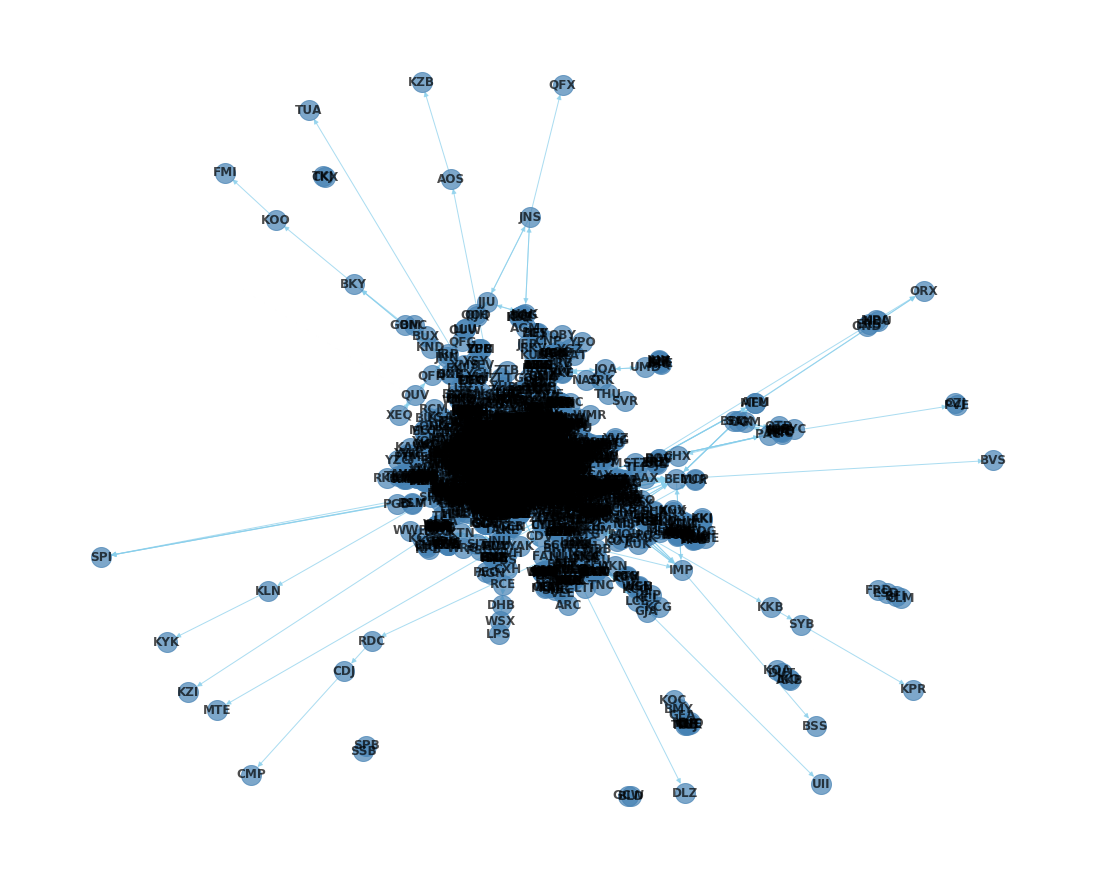

In [114]:
nx.draw(g, with_labels=True, node_color="steelblue", node_size=400, font_weight='bold', 
        edge_color="skyblue", alpha=0.7)

# NOT SURE IF WE NEED THIS!!!

# The rest of the code below is from our previous project that we may need...

Next let's just add this function copied from https://thispointer.com/python-how-to-sort-a-dictionary-by-key-or-value/.  This will be needed later on for finding our top ten...

In [3]:
def sorted_dict(d):
    ms = sorted(d.items() , reverse=True, key=lambda x: x[1])
    return ms

__Disconnected Nodes 37 and 85__

Note that one line containing "37 85 1" was removed from the edges file beccause there were no edges between those two dolphins (numbers 37 and 85) and the rest of the graph.  They were far off on the side and it made the rest of the graph hard to visualize.

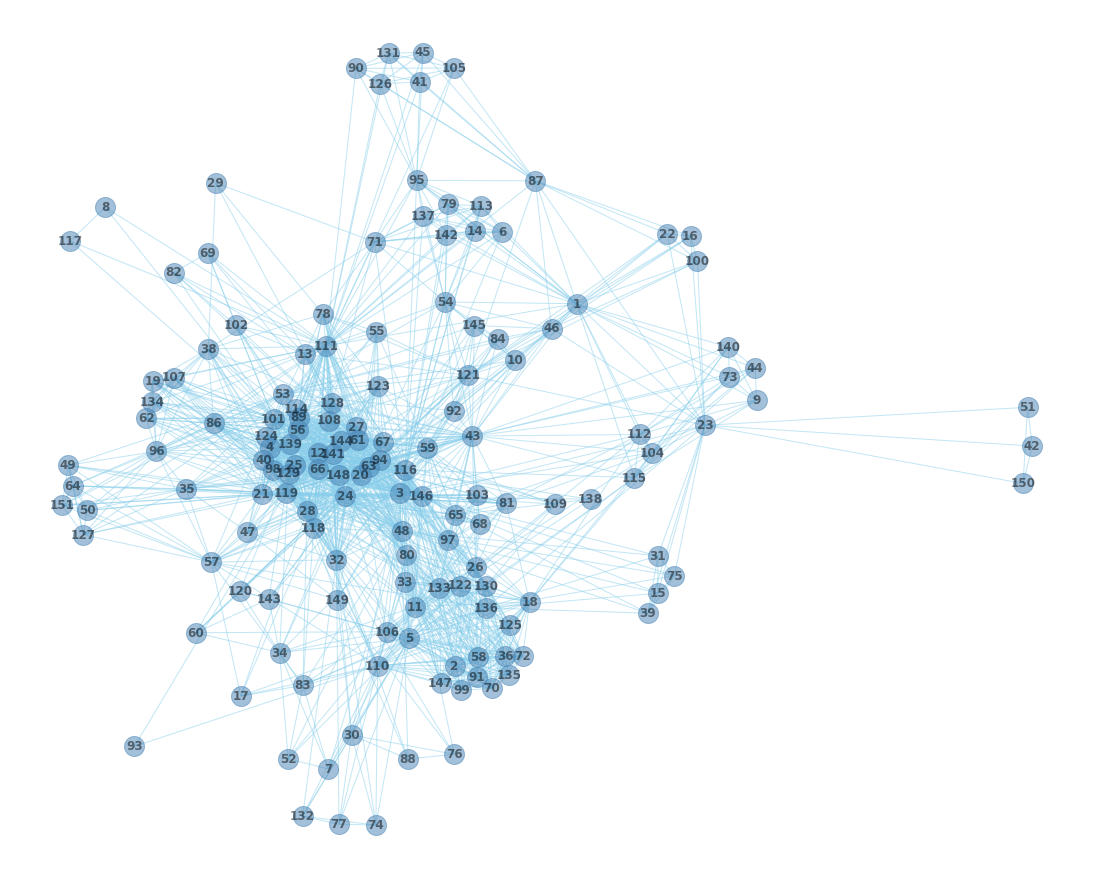

In [182]:
nx.draw(dolphins, with_labels=True, node_color="steelblue", node_size=400, font_weight='bold', 
        edge_color="skyblue", alpha=0.5)

The most interesting insight that immediately pops out from the graph is that there are 3 dolphins numbers 42, 51 and 150, that are only connected to the rest of the pod through one single other dolphin, number 23.  All 3 are connected to each other and to 23 but not to any other dolphin in the pod.  

Only one other dolphin seems to be even more isolated with less connections than 42, 51 and 150 who have 3 connections each.  Number 93 only has connections with 2 other dolphins in the pod total, numbers 57 and 110.  But those two are well connected to the rest of the pod.  

Two more dolphins, numbers 8 and 117 also have only 3 connections each, but unlike 42, 51 and 150 they each have connections to 2 other well-connected dolphins and each other.  

Remember there were also two dolphins, 37 and 85, who were deleted from the file because they had no connections to the rest of the pod at all.  Their only edge was one that connected the two of them to each other.  So those 2 are in fact the most isolated of the group.

All other dolphins in the pod have at least 4 connections but most have many more than that.  

This structure looks a lot like I would guess some human networks might look.  There are some outlier "loner" or "outcast" dolphins who have limited social connections compared to the majorty of their peers.  

## Metrics and Analysis

### Eccentricity, Radius, and Diameter

The __eccentricity__ of a node is the largest number of vertices or edges that must be traversed in order to travel from a node to another within a graph.  All minimum distances between that node and all others are calculated and the maximum minimum distance is the node's eccentricity.

Graph __diameter__ is the largest number of vertices or edges that must be traversed in order to travel from *any* one node to another within a graph.  All minimum distances between any two nodes are calculated and then the maximum of these miniumum distances is the diameter of the graph.  

Graph __radius__ is the minimum of these minimum distances between any two nodes.

Text(0, 0.5, 'Frequency')

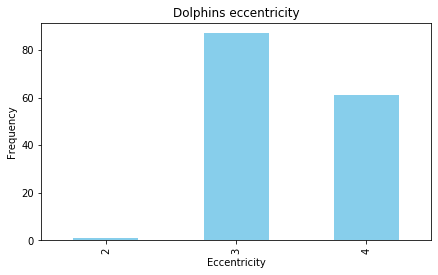

In [183]:
dolphin_ecc = pd.DataFrame((nx.eccentricity(dolphins).values()))[0].value_counts().sort_index()

plot = dolphin_ecc.plot(kind='bar',
                        color = "skyblue",
                        figsize=(7,4),
                        title="Dolphins eccentricity")
plot.set_xlabel("Eccentricity")
plot.set_ylabel("Frequency")

In [184]:
nx.radius(dolphins)

2

We have at least one dolphin that is connected to all other dolphins by maximum traveling through 2 edges. It seems incredible to me that this dolphin is so super social.

In [185]:
nx.diameter(dolphins)

4

The dolphin that very likely is the most socialy isolated still has to travel at most through 4 edges to be able to reach all other dolphins. It is not such a remote connection. In another words, dolphins appear to live in a very tight knit community. 

### Nodes, Edges, and Degree Centrality

In [186]:
print(nx.info(dolphins))

Name: 
Type: Graph
Number of nodes: 149
Number of edges: 1553
Average degree:  20.8456


The file contains data on 149 dolphins with 1,553 connections between them. On average one dolphin has approximately 21 connections.

__Degree centrality__ indicates the number of connections that a node (in this case a dolphin) has to other nodes (dolphins).  It is equal to the number of edges that are connected to that node in the graph.

In [187]:
d = nx.degree(dolphins)

In [188]:
min(dict(d).values())

2

At least one not very social dolphin had only 2 connections.

In [189]:
max(dict(d).values())

69

At the same time we have at least one dolphin with 69 connections.

Text(0.5, 1.0, 'Distribution of Degrees in Dolphin Network')

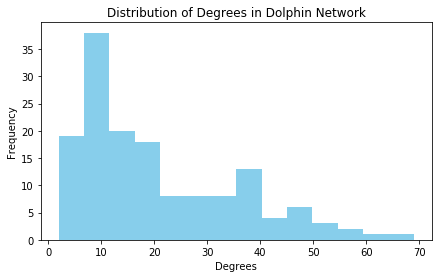

In [190]:
plt.figure(figsize=(7,4))
plt.hist(dict(d).values(), 14, color = "skyblue")
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees in Dolphin Network')

The distribution of degrees in the dolphin network is heavily left skewed indicating that the majority of dolphins have a relatively low number of connections while a smaller number are "connectors" in the network who have very high numbers of connections up to 3 times the average.  

In [191]:
# Find the top ten
ds = sorted_dict(dict(d))
ds[0:10]

[(116, 69),
 (111, 62),
 (24, 59),
 (119, 59),
 (3, 54),
 (63, 54),
 (101, 50),
 (129, 49),
 (146, 48),
 (61, 48)]

Our top ten dolphins had 48 or more connections each.

In [192]:
ds[-1]

(93, 2)

Dolphin number 93 had the minimum number of connections in the network at only 2.

### Closeness Centrality

__Closeness centrality__ tries to identify the most important or influential nodes within a graph based on their average distance to other nodes.  Closer nodes are able to more quickly and easily pass information to other nodes.  Higher numbers indicate greater "closeness" and thus more influence within the network.

In [193]:
d_cc = nx.closeness_centrality(dolphins)

In [194]:
# Find the top ten
d_cc_s = sorted_dict(d_cc)
d_cc_s[1:10]

[(111, 0.6244725738396625),
 (24, 0.6090534979423868),
 (119, 0.6090534979423868),
 (3, 0.6040816326530613),
 (63, 0.6040816326530613),
 (146, 0.5967741935483871),
 (61, 0.5896414342629482),
 (101, 0.5873015873015873),
 (129, 0.5849802371541502)]

We can see that dolphins that have the most connections are also the closest to other dolphins. 

In [195]:
d_cc_s[-1]

(51, 0.31223628691983124)

The lowest closeness score is for dolphin number 51 at 0.312.  Note that this is not the same dolphin with the lowest degree centrality, number 93.

Text(0.5, 1.0, 'Distribution of Closeness Metric in Dolphin Network')

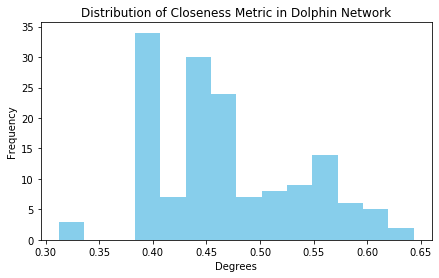

In [196]:
plt.figure(figsize=(7,4))
plt.hist(dict(d_cc).values(), 14, color = "skyblue")
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.title('Distribution of Closeness Metric in Dolphin Network')

The distribution of closeness scores is less skewed than the distribution for degrees.  This indicates that even dolphins with less connections can be influential based on their closeness to other more connected dolphins.  

### Betweenness Centrality

__Betweenness centrality__ is a measure of the number of shortest paths that pass through a node.  Betweenness attempts to identify "boundary spanners" who link otherwise disconnected parts of a network.

In [197]:
d_bc = nx.betweenness_centrality(dolphins)

In [198]:
# Find the top ten
d_bc_s = sorted_dict(d_bc)
d_bc_s[1:10]

[(116, 0.10660585436405577),
 (3, 0.060692540414938344),
 (43, 0.058793411707507494),
 (119, 0.05645899125681446),
 (23, 0.050878493844890536),
 (146, 0.04972310488868277),
 (48, 0.04710882989398321),
 (32, 0.03789480604036151),
 (24, 0.03705698783345232)]

Again, we see a lot of the same dolphins display high level of betweenness, or in another words the most connections between different dolphins pass through these 10 dolphins.

In [199]:
d_bc_s[-1]

(93, 0.0)

### Eigenvector Centrality

__Eigenvector centrality__ can help us find so called "Gray Cardinals", or nodes that may have influence through their connections to other highly connected nodes.  

In [200]:
d_ec = nx.eigenvector_centrality(dolphins)

In [201]:
# Find the top ten
d_ec_s = sorted_dict(d_ec)
d_ec_s[1:10]

[(24, 0.18686265791454115),
 (63, 0.18329374100634405),
 (119, 0.18150292300896842),
 (129, 0.1739888773410532),
 (101, 0.17203582804671796),
 (61, 0.17105178546891275),
 (56, 0.16895451104022574),
 (40, 0.1673073937313991),
 (111, 0.16710196658913679)]

Eigenvector calculations that help to identify the most influential members of network list many of the same dolphins.

In [202]:
d_ec_s[-1]

(51, 0.00043286176783971015)

### 'Elite' Group

By merging the top ten lists for degree, closeness, and betweenness centrality we can find the most influential dolphins in our network.  

In [203]:
# Code adapted from Social Network Analysis for Startups chapter 3 page 54

## make a list of the elite group by merging top ten groups for 3 centrality metrics 
names1 = [x[0] for x in ds[:10]]
names2 = [x[0] for x in d_cc_s[:10]]
names3 = [x[0] for x in d_bc_s[:10]]

## use Python sets to compute a union of the sets 
names = list(set(names1) | set(names2) | set(names3))

## build a table with centralities 
data = [[name,d[name],d_cc[name],d_bc[name]] for name in names]
pd.DataFrame.from_records(data, columns=['Dolphin', 'Degree', 'Closeness', 'Betweenness'])

,Dolphin,Degree,Closeness,Betweenness
0,32,43,0.562738,0.037895
1,129,49,0.584980,0.020889
2,3,54,0.604082,0.060693
3,101,50,0.587302,0.030207
4,43,47,0.564885,0.058793
5,111,62,0.624473,0.125630
6,48,42,0.573643,0.047109
7,146,48,0.596774,0.049723
8,116,69,0.643478,0.106606
9,23,17,0.449848,0.050878


#### Identify 'Gray Cardinals'

In [204]:
names4 = [x[0] for x in d_ec_s[:10]]

names = list(set(names4) - (set(names1) | set(names2) | set(names3)))

data = [[name,d[name],d_cc[name],d_bc[name],d_ec[name]] for name in names]
pd.DataFrame.from_records(data, columns=['Dolphin', 'Degree', 'Closeness', 'Betweenness', 'Eigenvector'])

,Dolphin,Degree,Closeness,Betweenness,Eigenvector
0,40,44,0.564885,0.007760,0.167307
1,56,47,0.578125,0.012737,0.168955


There are two 'Gray Cardinal' dolphins (numbers 40 and 56) in the top 10 eigenvector centrality list that are not in the combined top ten lists for the other 3 centrality measures.  These are the so called "Gray Cardinals" who while not so well-connected themselves are connected to others who are well-connected.  

From our analysis, we see the incredible value that graph theory brings to biology in helping us to identify the leaders of dolphin network. We can see that dolphins vary in their sociability widely.  The next step would be to see if gender, age, or physical size of dolphin influences social position in the network.

## Dolphin and Macaques Social Networks: Simularities and Differences.

__1. Network Size.__ 149 for dolphins and 62 for macaques. Dolphins' social groups are bigger than macaques, which would mean that they are harder to maintain and they are more likely to be less connected. Also, interestingly macaques did not have disconnected members, while dolphins had 2 members that were disconnected from the main network.

__2. Average Number of Connections.__ 21 for dolphins and 38 for macaques. Dolphins generally do not have as many connections as macaques do. I do not necessary see it as a bad thing. It is hard to have quality relationships when you interact with 38 individuals on a regular basis. So, it might become matter of quality vs quanity.

__3. Minimum/maximum Number of Connections.__ There is at least one dolphin that had only 2 connections, while the very minimum macaques had was 17. We could interpret it as dolphins being more independent and being able to survive on their own, while macaques cannot live outside of a big group. The maximum connections, a dolphin had, was 69 or almost half of the network, while a monkey had 55 connections or almost every single member of the group! 

__4. Distribution of Degrees.__ Dolphins' distribution is heavily left skewed, while macaques' distribution is normally distributed. We can say that most dolphins do not have that many connections, while there are a few that are extremly well connected. For monkey's it is more balanced, we have some with relatively few connections and some with really a lot, but most are in the middle. 

__5. Closeness Centrality.__ Dolphins are not that closely centered as macaques, which confirms our prior findings.

__6. Betweenness Centrality.__ Betweenness dolphins and macaques are similar with macaques being slightly higher, are we can say that they are simularly centralized, with macaques maybe being a little bit more.

__7. Eigenvector Centrality.__ The highest values are simular for both dolphins and macaques, which would mean that leaders play simular roles in both groups. However, a lowest value for dolphins is almost 0, which means that this member is practically has no importance for the dolphin network. While no macaques has value close to zero. It means that all monkeys play at least some role in group. 

__8. Radius/Diameter.__ Radius is the same for the both networks - 2. So both groups have highly connected individuals. However, diameter is smaller for macaques - 2 vs 4 for dolphins. Which means that monkeys are much tighter group and much more uniformly connected.

__9. In conclusion.__ All indicators show that social interactions are more critical for macaques. No macaques can exist outside of network. While dolphins' network allows for bigger variability, with some members being extremly social and others are not.


## References

[1] Ryan A. Rossi, Nesreen K. Ahmed, and others. (2015). The Network Data Repository with Interactive Graph Analytics and Visualization. Retrieved from http://networkrepository.com

[2] https://en.wikipedia.org/wiki/Dolphin

[3] http://pin.primate.wisc.edu/factsheets/entry/rhesus_macaque/behav

## YouTube Video Presentation Link

https://www.youtube.com/watch?v=LNZpDo-YVtg